# Setup

In [1]:
import gc
import time
import warnings

gc.enable()
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.precision', 4)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import clear_output

import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

SEED = 2024

In [2]:
#Check GPU availability
import subprocess
try:
    subprocess.check_output('nvidia-smi')
    DEVICE = 'cuda'
except Exception:
    DEVICE = 'cpu'

print(f'Available device: {DEVICE}')

Available device: cpu


In [3]:
DATA_DIR = '/kaggle/input/bitgrit-crypto-price-prediction'

train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')
sample_sub = pd.read_csv(f'{DATA_DIR}/solution_format.csv')

In [4]:
TARGET = 'Target'

In [5]:
train.columns

Index(['ID', 'TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd', 'feature_10_A',
       'feature_10_B', 'feature_10_F', 'feature_10_G', 'feature_1_A',
       'feature_1_B', 'feature_1_C', 'feature_1_D', 'feature_1_E',
       'feature_1_F', 'feature_1_G', 'feature_2_A', 'feature_2_B',
       'feature_2_C', 'feature_2_D', 'feature_2_E', 'feature_2_F',
       'feature_2_G', 'feature_3_A', 'feature_3_B', 'feature_3_C',
       'feature_3_D', 'feature_3_E', 'feature_3_F', 'feature_3_G',
       'feature_4_A', 'feature_4_B', 'feature_4_C', 'feature_4_E',
       'feature_4_F', 'feature_4_G', 'feature_5_A', 'feature_5_B',
       'feature_5_C', 'feature_5_D', 'feature_5_E', 'feature_5_F',
       'feature_5_G', 'feature_6_A', 'feature_6_B', 'feature_6_C',
       'feature_6_D', 'feature_6_E', 'feature_6_F', 'feature_6_G',
       'feature_7_A', 'feature_7_B', 'feature_7_C', 'feature_7_D',
       'feature_7_E', 'feature_7_F', 'feature_7_G', 'feature_8_A',
       'feature_8_B', 'feature_8_C', 'feature_

# Missing values

In [6]:
(train.isna().sum() / len(train) * 100).to_frame().T

,ID,TR_1_EventInd,TR_2_EventInd,TR_3_EventInd,feature_10_A,feature_10_B,feature_10_F,feature_10_G,feature_1_A,feature_1_B,feature_1_C,feature_1_D,feature_1_E,feature_1_F,feature_1_G,feature_2_A,feature_2_B,feature_2_C,feature_2_D,feature_2_E,feature_2_F,feature_2_G,feature_3_A,feature_3_B,feature_3_C,feature_3_D,feature_3_E,feature_3_F,feature_3_G,feature_4_A,feature_4_B,feature_4_C,feature_4_E,feature_4_F,feature_4_G,feature_5_A,feature_5_B,feature_5_C,feature_5_D,feature_5_E,feature_5_F,feature_5_G,feature_6_A,feature_6_B,feature_6_C,feature_6_D,feature_6_E,feature_6_F,feature_6_G,feature_7_A,feature_7_B,feature_7_C,feature_7_D,feature_7_E,feature_7_F,feature_7_G,feature_8_A,feature_8_B,feature_8_C,feature_8_D,feature_8_E,feature_8_F,feature_8_G,feature_9_A,feature_9_B,feature_9_C,feature_9_D,feature_9_E,feature_9_F,feature_9_G,feature_X_A,feature_X_B,feature_X_C,feature_X_D,index_1,index_2,index_3,Target
0,0.0,97.2556,97.7068,96.3534,16.8421,30.7143,16.8421,16.8421,30.6767,30.6767,30.8271,30.8271,34.5113,30.6767,30.6767,30.6767,30.6767,30.8271,30.8271,34.5113,30.6767,30.6767,30.6767,30.6767,30.8271,30.8271,34.5113,30.6767,30.6767,28.0075,28.1203,29.1729,43.1203,28.0075,28.0075,30.7143,30.7143,30.8647,30.8647,34.5489,30.7143,30.7143,30.6767,30.6767,30.8271,30.8271,34.5113,30.6767,30.6767,30.6767,30.6767,30.8271,30.8271,34.5113,30.6767,30.6767,30.6767,30.6767,30.8271,30.8271,34.5113,30.6767,30.6767,30.7143,30.7143,30.8647,30.8647,34.5489,30.7143,30.7143,0.0,0.0,0.0,0.0,96.4286,96.4286,96.4286,0.0


In [7]:
(test.isna().sum() / len(test) * 100).to_frame().T

,ID,TR_1_EventInd,TR_2_EventInd,TR_3_EventInd,feature_10_A,feature_10_B,feature_10_F,feature_10_G,feature_1_A,feature_1_B,feature_1_C,feature_1_D,feature_1_E,feature_1_F,feature_1_G,feature_2_A,feature_2_B,feature_2_C,feature_2_D,feature_2_E,feature_2_F,feature_2_G,feature_3_A,feature_3_B,feature_3_C,feature_3_D,feature_3_E,feature_3_F,feature_3_G,feature_4_A,feature_4_B,feature_4_C,feature_4_E,feature_4_F,feature_4_G,feature_5_A,feature_5_B,feature_5_C,feature_5_D,feature_5_E,feature_5_F,feature_5_G,feature_6_A,feature_6_B,feature_6_C,feature_6_D,feature_6_E,feature_6_F,feature_6_G,feature_7_A,feature_7_B,feature_7_C,feature_7_D,feature_7_E,feature_7_F,feature_7_G,feature_8_A,feature_8_B,feature_8_C,feature_8_D,feature_8_E,feature_8_F,feature_8_G,feature_9_A,feature_9_B,feature_9_C,feature_9_D,feature_9_E,feature_9_F,feature_9_G,feature_X_A,feature_X_B,feature_X_C,feature_X_D,index_1,index_2,index_3
0,0.0,98.048,98.3483,95.3453,16.5165,33.033,16.5165,16.5165,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,30.7808,30.7808,33.033,45.7958,30.7808,30.7808,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,32.8829,32.8829,33.033,33.033,37.2372,32.8829,32.8829,0.0,0.0,0.0,0.0,97.8979,97.8979,97.8979


# Feature exploration

In [8]:
def cat_dist(f, norm=True):
    display(pd.concat(
        [
            train[f].value_counts(normalize=norm, dropna=False).rename('train'),
            test[f].value_counts(normalize=norm, dropna=False).rename('test')
        ],
        axis=1
    ))

In [9]:
def cont_dist(f, clip=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    ax[0].set_title('Train vs Test')
    sns.kdeplot(x=f, data=train, cut=0, ax=ax[0], clip=clip, label='train')
    sns.kdeplot(x=f, data=test, cut=0, ax=ax[0], clip=clip, label='test')
    ax[0].legend()
    
    ax[1].set_title('Feature vs Target')
    sns.kdeplot(x=f, data=train, hue=TARGET, cut=0, ax=ax[1], clip=clip)
    
    fig.tight_layout()
    plt.show()

### TR_x_EventInd

In [10]:
cat_dist('TR_1_EventInd')

,train,test
TR_1_EventInd,,
NaN,0.9726,0.9805
1.0,0.0274,0.0195


In [11]:
cat_dist('TR_2_EventInd')

,train,test
TR_2_EventInd,,
NaN,0.9771,0.9835
1.0,0.0229,0.0165


In [12]:
cat_dist('TR_3_EventInd')

,train,test
TR_3_EventInd,,
NaN,0.9635,0.9535
1.0,0.0365,0.0465


In [13]:
train['TR_1_EventInd'] = train['TR_1_EventInd'].fillna(0).astype('int')
test['TR_1_EventInd'] = test['TR_1_EventInd'].fillna(0).astype('int')

train['TR_2_EventInd'] = train['TR_2_EventInd'].fillna(0).astype('int')
test['TR_2_EventInd'] = test['TR_2_EventInd'].fillna(0).astype('int')

train['TR_3_EventInd'] = train['TR_3_EventInd'].fillna(0).astype('int')
test['TR_3_EventInd'] = test['TR_3_EventInd'].fillna(0).astype('int')

In [14]:
train.groupby('TR_1_EventInd')[TARGET].value_counts(normalize=True)

TR_1_EventInd  Target
0              1         0.5686
               0         0.4314
1              1         0.5342
               0         0.4658
Name: proportion, dtype: float64

In [15]:
train.groupby('TR_2_EventInd')[TARGET].value_counts(normalize=True)

TR_2_EventInd  Target
0              1         0.5683
               0         0.4317
1              1         0.5410
               0         0.4590
Name: proportion, dtype: float64

In [16]:
train.groupby('TR_3_EventInd')[TARGET].value_counts(normalize=True)

TR_3_EventInd  Target
0              1         0.5669
               0         0.4331
1              1         0.5876
               0         0.4124
Name: proportion, dtype: float64

In [17]:
train.groupby(['TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd'])[TARGET].value_counts(normalize=True)

TR_1_EventInd  TR_2_EventInd  TR_3_EventInd  Target
0              0              0              1         0.5693
                                             0         0.4307
                              1              1         0.5814
                                             0         0.4186
               1              0              1         0.5185
                                             0         0.4815
1              0              0              0         0.5091
                                             1         0.4909
                              1              1         0.6364
                                             0         0.3636
               1              0              1         0.7143
                                             0         0.2857
Name: proportion, dtype: float64

In [18]:
train.groupby(['TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd'])[TARGET].value_counts()

TR_1_EventInd  TR_2_EventInd  TR_3_EventInd  Target
0              0              0              1         1393
                                             0         1054
                              1              1           50
                                             0           36
               1              0              1           28
                                             0           26
1              0              0              0           28
                                             1           27
                              1              1            7
                                             0            4
               1              0              1            5
                                             0            2
Name: count, dtype: int64

### index_1-3

In [19]:
cat_dist('index_1')

,train,test
index_1,,
NaN,0.9643,0.9790
0.0,0.0214,0.0135
2.0,0.0056,0.0015
1.0,0.0026,0.0015
4.0,0.0026,0.0015
3.0,0.0023,0.0015
5.0,0.0008,NaN
7.0,0.0004,NaN
6.0,NaN,0.0015


In [20]:
train['index_2'].unique(), test['index_2'].unique()

(array([  0.,  nan,   6.,  73.,  36.,   1.,  11.,  31.,   5.,  61.,   8.,
         29.,   4.,  34.,  19.,   9., 100.,  38.,  21.,  15.,  12.,  82.,
         18.,  22.,  26.,   7.]),
 array([nan,  7.,  0.,  9., 21.,  5.]))

In [21]:
train['index_3'].unique(), test['index_3'].unique()

(array([  1.,  nan,   6.,  13.,  42.,  31.,  50.,   9.,   8.,  37.,   4.,
         27.,   7.,  55.,  20.,  19.,  56.,  25.,  10.,  16.,  43., 100.,
         86.,  14.,   2.,  18.,  15.,  29.,  24.,  46.,  11.,   3.,   0.,
         12.,  17.,  34.]),
 array([nan, 21., 19.,  1., 16., 10.,  8., 23., 13., 97., 14., 36., 24.]))

Possibly percentages since maximum value is exactly 100.

### feature_X_x

**feature_X_A**

In [22]:
train['feature_X_A'].nunique()

2

In [23]:
cat_dist('feature_X_A')

,train,test
feature_X_A,,
1,0.5256,0.5571
0,0.4744,0.4429


In [24]:
train.groupby('feature_X_A')[TARGET].value_counts(normalize=True)

feature_X_A  Target
0            1         0.5666
             0         0.4334
1            1         0.5687
             0         0.4313
Name: proportion, dtype: float64

No split based on this variable. Providing no information on its own.

**feature_X_B**

In [25]:
train['feature_X_B'].nunique(), test['feature_X_B'].nunique()

(189, 126)

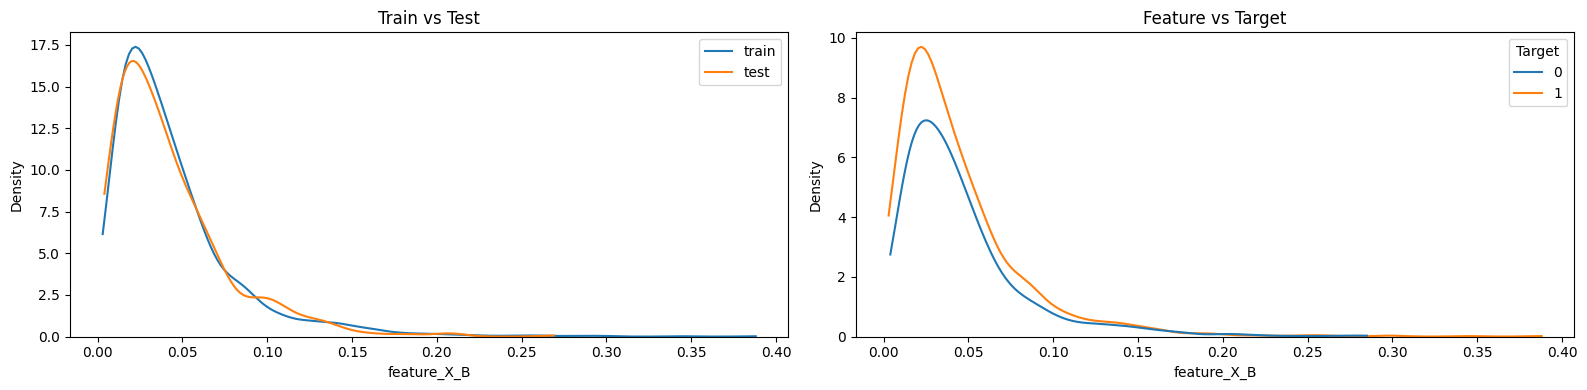

In [26]:
cont_dist('feature_X_B')

**feature_X_C**

In [27]:
train.shape[0], train['feature_X_C'].nunique()

(2660, 2660)

In [28]:
test.shape[0], test['feature_X_C'].nunique()

(666, 666)

In [29]:
train['feature_X_C'].unique()[:10]

array([ 1.54245568,  1.28747292,  0.25150108,  1.6737832 ,  0.26340646,
        0.74578836,  0.81692102, -1.24439402,  0.08979781, -0.72765139])

All values are unique. Could be co-incidental due to continuous data, or obfuscated values for a unique identifier.

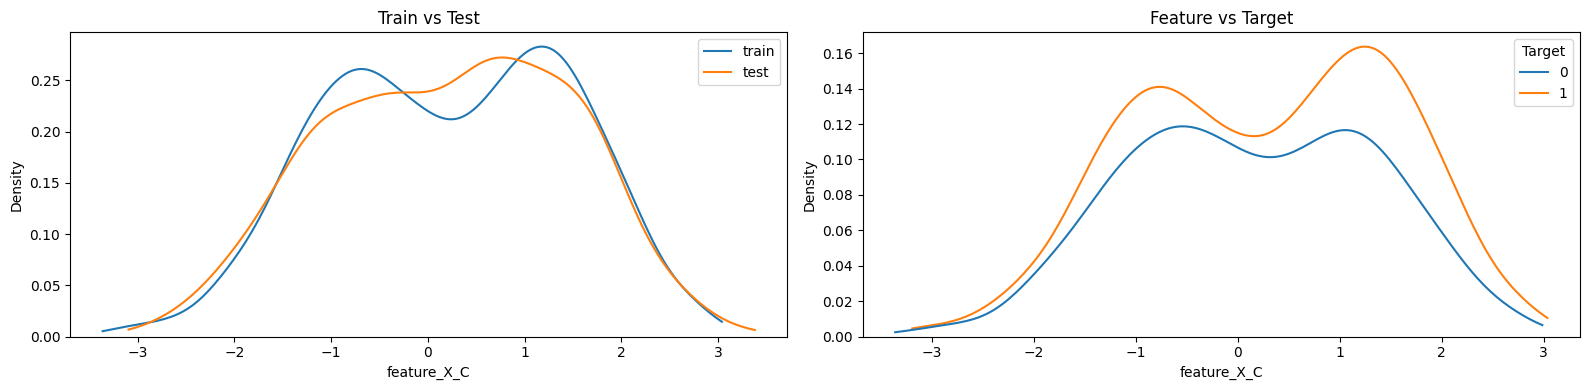

In [30]:
cont_dist('feature_X_C')

**feature_X_D**

In [31]:
train.shape[0], train['feature_X_D'].nunique()

(2660, 2660)

In [32]:
test.shape[0], test['feature_X_D'].nunique()

(666, 666)

In [33]:
train['feature_X_D'].unique()[:10]

array([-0.27472673, -1.1406259 , -1.22156692,  0.52779646, -0.301984  ,
       -0.9628409 , -0.02849252, -0.6477786 , -1.17012439,  1.17614048])

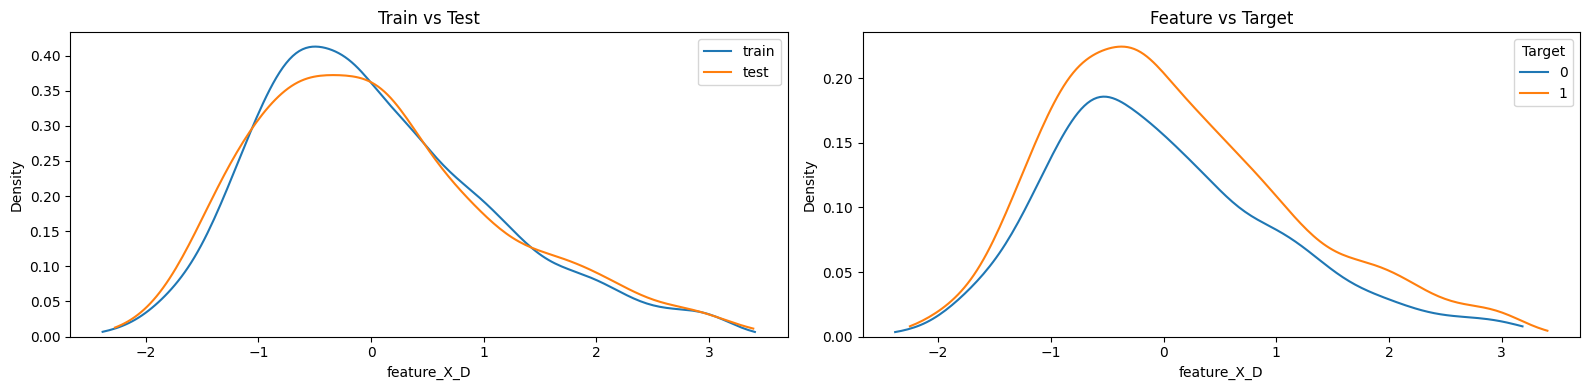

In [34]:
cont_dist('feature_X_D')

Same situation as *feature_X_C*.

### feature_10_x

**feature_10_A**

In [35]:
train['feature_10_A'].nunique()

2

In [36]:
cat_dist('feature_10_A')

,train,test
feature_10_A,,
0.0,0.5038,0.5135
1.0,0.3278,0.3213
NaN,0.1684,0.1652


In [37]:
train.groupby('feature_10_A', dropna=False)[TARGET].value_counts(normalize=True)

feature_10_A  Target
0.0           1         0.5709
              0         0.4291
1.0           1         0.5573
              0         0.4427
NaN           1         0.5781
              0         0.4219
Name: proportion, dtype: float64

In [38]:
train['feature_10_A'] = train['feature_10_A'].fillna(0).astype('int')
test['feature_10_A'] = test['feature_10_A'].fillna(0).astype('int')

**feature_10_B**

In [39]:
train['feature_10_B'].nunique()

110

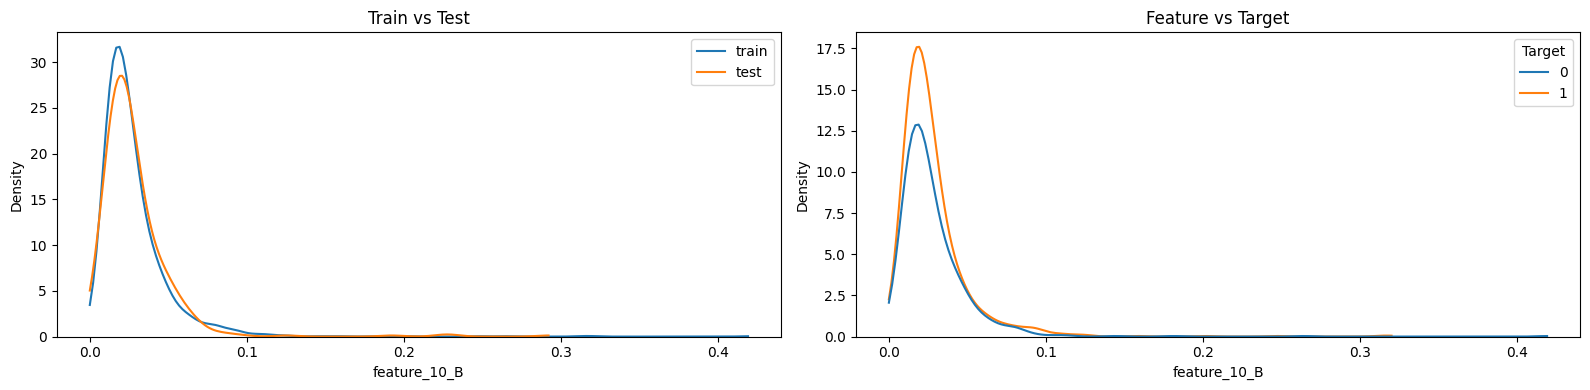

In [40]:
cont_dist('feature_10_B')

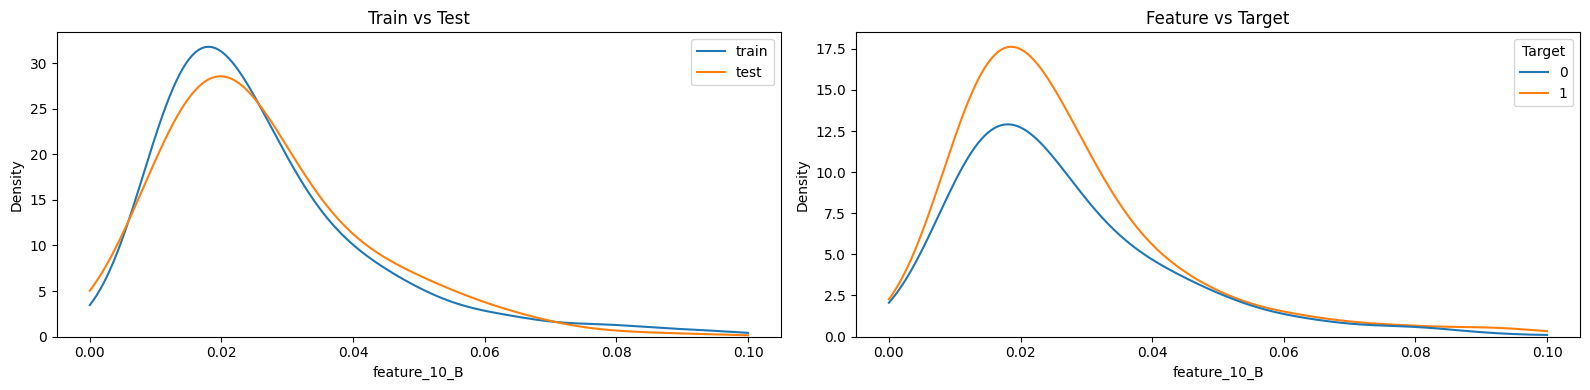

In [41]:
cont_dist('feature_10_B', clip=(0, 0.1))

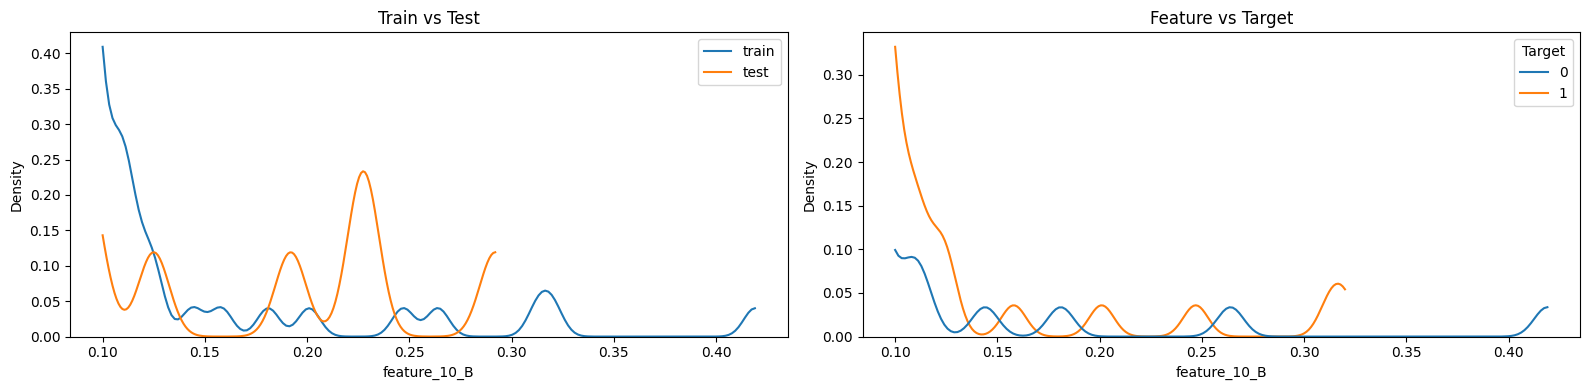

In [42]:
cont_dist('feature_10_B', clip=(0.1, 0.5))

**feature_10_F**

In [43]:
train['feature_10_F'].nunique()

1

In [44]:
cat_dist('feature_10_F')

,train,test
feature_10_F,,
0.0,0.8316,0.8348
NaN,0.1684,0.1652


In [45]:
train.groupby('feature_10_F', dropna=False)[TARGET].value_counts(normalize=True)

feature_10_F  Target
0.0           1         0.5656
              0         0.4344
NaN           1         0.5781
              0         0.4219
Name: proportion, dtype: float64

In [46]:
train['feature_10_F_missing'] = train.feature_10_F.isna().astype('int')
test['feature_10_F_missing'] = test.feature_10_F.isna().astype('int')

**feature_10_G**

In [47]:
train['feature_10_G'].nunique()

5

In [48]:
cat_dist('feature_10_G')

,train,test
feature_10_G,,
0.0,0.5692,0.5766
1.0,0.1767,0.1622
NaN,0.1684,0.1652
2.0,0.0594,0.0721
3.0,0.0207,0.0165
4.0,0.0056,0.0075


In [49]:
train.groupby('feature_10_G', dropna=False)[TARGET].value_counts(normalize=True)

feature_10_G  Target
0.0           1         0.5634
              0         0.4366
1.0           1         0.5766
              0         0.4234
2.0           1         0.5823
              0         0.4177
3.0           0         0.5273
              1         0.4727
4.0           1         0.6000
              0         0.4000
NaN           1         0.5781
              0         0.4219
Name: proportion, dtype: float64

### feature_[1 - 9]_A

In [50]:
feats_A = [f'feature_{i}_A' for i in range(1, 10)]

In [51]:
train[feats_A].nunique().to_frame().T

,feature_1_A,feature_2_A,feature_3_A,feature_4_A,feature_5_A,feature_6_A,feature_7_A,feature_8_A,feature_9_A
0,2,2,2,2,2,2,2,2,2


In [52]:
(train[feats_A].isna().sum() / len(train) * 100).to_frame().T

,feature_1_A,feature_2_A,feature_3_A,feature_4_A,feature_5_A,feature_6_A,feature_7_A,feature_8_A,feature_9_A
0,30.6767,30.6767,30.6767,28.0075,30.7143,30.6767,30.6767,30.6767,30.7143


In [53]:
for col in feats_A:
    print(f'{col}: {train[col].unique()}')

feature_1_A: [nan  1.  0.]
feature_2_A: [nan  0.  1.]
feature_3_A: [nan  0.  1.]
feature_4_A: [nan  0.  1.]
feature_5_A: [nan  1.  0.]
feature_6_A: [nan  1.  0.]
feature_7_A: [nan  0.  1.]
feature_8_A: [nan  1.  0.]
feature_9_A: [nan  0.  1.]


In [54]:
cat_dist('feature_1_A')

,train,test
feature_1_A,,
0.0,0.3602,0.3288
1.0,0.3331,0.3423
NaN,0.3068,0.3288


In [55]:
train.groupby('feature_1_A', dropna=False)[TARGET].value_counts(normalize=True)

feature_1_A  Target
0.0          1         0.5678
             0         0.4322
1.0          1         0.5632
             0         0.4368
NaN          1         0.5723
             0         0.4277
Name: proportion, dtype: float64

### feature_[1 - 9]_B

In [56]:
feats_B = [f'feature_{i}_B' for i in range(1, 10)]

In [57]:
train[feats_B].nunique().to_frame().T

,feature_1_B,feature_2_B,feature_3_B,feature_4_B,feature_5_B,feature_6_B,feature_7_B,feature_8_B,feature_9_B
0,34,45,66,35,101,61,56,124,164


In [58]:
(train[feats_B].isna().sum() / len(train) * 100).to_frame().T

,feature_1_B,feature_2_B,feature_3_B,feature_4_B,feature_5_B,feature_6_B,feature_7_B,feature_8_B,feature_9_B
0,30.6767,30.6767,30.6767,28.1203,30.7143,30.6767,30.6767,30.6767,30.7143


In [59]:
train['feature_1_B'].unique()

array([  nan, 0.004, 0.005, 0.014, 0.013, 0.006, 0.008, 0.01 , 0.011,
       0.02 , 0.007, 0.003, 0.009, 0.015, 0.012, 0.016, 0.029, 0.018,
       0.019, 0.021, 0.002, 0.017, 0.026, 0.05 , 0.025, 0.024, 0.031,
       0.04 , 0.03 , 0.032, 0.023, 0.045, 0.022, 0.054, 0.037])

In [60]:
train['feature_9_B'].unique()[:40]

array([  nan, 0.032, 0.033, 0.084, 0.166, 0.042, 0.039, 0.056, 0.049,
       0.082, 0.047, 0.05 , 0.093, 0.037, 0.065, 0.063, 0.052, 0.064,
       0.104, 0.098, 0.04 , 0.077, 0.176, 0.057, 0.08 , 0.075, 0.088,
       0.048, 0.027, 0.03 , 0.055, 0.059, 0.074, 0.026, 0.094, 0.114,
       0.034, 0.058, 0.043, 0.038])

### feature_[1 - 9]_C

In [61]:
feats_C = [f'feature_{i}_C' for i in range(1, 10)]

In [62]:
train[feats_C].nunique().to_frame().T

,feature_1_C,feature_2_C,feature_3_C,feature_4_C,feature_5_C,feature_6_C,feature_7_C,feature_8_C,feature_9_C
0,1840,1840,1840,1884,1839,1840,1840,1840,1838


In [63]:
(train[feats_C].isna().sum() / len(train) * 100).to_frame().T

,feature_1_C,feature_2_C,feature_3_C,feature_4_C,feature_5_C,feature_6_C,feature_7_C,feature_8_C,feature_9_C
0,30.8271,30.8271,30.8271,29.1729,30.8647,30.8271,30.8271,30.8271,30.8647


In [64]:
train['feature_1_C'].unique()[:10]

array([        nan, -0.22441409, -1.37254816,  1.66410753,  2.67888067,
        1.86530158,  1.60413983,  0.54656567, -1.18263472, -0.66988578])

In [65]:
(~train.feature_1_C.isna()).sum()

1840

All non-missing values are unique. Same as feature_X_C and feature_X_D.

### feature_[1 - 9]_D

In [66]:
feats_D = [f'feature_{i}_D' for i in range(1, 10)]
feats_D.remove('feature_4_D')  # not in dataset

In [67]:
train[feats_D].nunique().to_frame().T

,feature_1_D,feature_2_D,feature_3_D,feature_5_D,feature_6_D,feature_7_D,feature_8_D,feature_9_D
0,1840,1840,1840,1839,1840,1840,1840,1839


In [68]:
(train[feats_D].isna().sum() / len(train) * 100).to_frame().T

,feature_1_D,feature_2_D,feature_3_D,feature_5_D,feature_6_D,feature_7_D,feature_8_D,feature_9_D
0,30.8271,30.8271,30.8271,30.8647,30.8271,30.8271,30.8271,30.8647


Same as previous.

### feature_[1 - 9]_E

In [69]:
feats_E = [f'feature_{i}_E' for i in range(1, 10)]

In [70]:
train[feats_E].nunique().to_frame().T

,feature_1_E,feature_2_E,feature_3_E,feature_4_E,feature_5_E,feature_6_E,feature_7_E,feature_8_E,feature_9_E
0,1742,1742,1742,1513,1741,1742,1742,1741,1721


In [71]:
(train[feats_E].isna().sum() / len(train) * 100).to_frame().T

,feature_1_E,feature_2_E,feature_3_E,feature_4_E,feature_5_E,feature_6_E,feature_7_E,feature_8_E,feature_9_E
0,34.5113,34.5113,34.5113,43.1203,34.5489,34.5113,34.5113,34.5113,34.5489


In [72]:
train['feature_1_E'].unique()[:10]

array([         nan, 122.79364306, 116.51550021, 123.70828588,
       110.85007144, 133.7343569 , 166.36664246, 167.21085684,
       118.67364314, 162.47799934])

### feature_[1 - 9]_F

In [73]:
feats_F = [f'feature_{i}_F' for i in range(1, 10)]

In [74]:
train[feats_F].nunique().to_frame().T

,feature_1_F,feature_2_F,feature_3_F,feature_4_F,feature_5_F,feature_6_F,feature_7_F,feature_8_F,feature_9_F
0,2,2,2,2,2,2,2,2,2


In [75]:
(train[feats_F].isna().sum() / len(train) * 100).to_frame().T

,feature_1_F,feature_2_F,feature_3_F,feature_4_F,feature_5_F,feature_6_F,feature_7_F,feature_8_F,feature_9_F
0,30.6767,30.6767,30.6767,28.0075,30.7143,30.6767,30.6767,30.6767,30.7143


In [76]:
train.loc[train.feature_1_F.isna()].sample()

,ID,TR_1_EventInd,TR_2_EventInd,TR_3_EventInd,feature_10_A,feature_10_B,feature_10_F,feature_10_G,feature_1_A,feature_1_B,feature_1_C,feature_1_D,feature_1_E,feature_1_F,feature_1_G,feature_2_A,feature_2_B,feature_2_C,feature_2_D,feature_2_E,feature_2_F,feature_2_G,feature_3_A,feature_3_B,feature_3_C,feature_3_D,feature_3_E,feature_3_F,feature_3_G,feature_4_A,feature_4_B,feature_4_C,feature_4_E,feature_4_F,feature_4_G,feature_5_A,feature_5_B,feature_5_C,feature_5_D,feature_5_E,feature_5_F,feature_5_G,feature_6_A,feature_6_B,feature_6_C,feature_6_D,feature_6_E,feature_6_F,feature_6_G,feature_7_A,feature_7_B,feature_7_C,feature_7_D,feature_7_E,feature_7_F,feature_7_G,feature_8_A,feature_8_B,feature_8_C,feature_8_D,feature_8_E,feature_8_F,feature_8_G,feature_9_A,feature_9_B,feature_9_C,feature_9_D,feature_9_E,feature_9_F,feature_9_G,feature_X_A,feature_X_B,feature_X_C,feature_X_D,index_1,index_2,index_3,Target,feature_10_F_missing
2429,2430,0,0,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.021,2.12,-0.6676,NaN,NaN,NaN,1,0


In [77]:
for col in feats_F:
    print(f'{col}: {train[col].unique()}')

feature_1_F: [nan  1.  0.]
feature_2_F: [nan  1.  0.]
feature_3_F: [nan  1.  0.]
feature_4_F: [nan  0.  1.]
feature_5_F: [nan  1.  0.]
feature_6_F: [nan  1.  0.]
feature_7_F: [nan  1.  0.]
feature_8_F: [nan  0.  1.]
feature_9_F: [nan  0.  1.]


In [78]:
cat_dist('feature_1_F')

,train,test
feature_1_F,,
1.0,0.4109,0.3874
NaN,0.3068,0.3288
0.0,0.2823,0.2838


In [79]:
train.groupby('feature_1_F', dropna=False)[TARGET].value_counts(normalize=True)

feature_1_F  Target
0.0          1         0.5593
             0         0.4407
1.0          1         0.5700
             0         0.4300
NaN          1         0.5723
             0         0.4277
Name: proportion, dtype: float64

### feature_[1 - 9]_G

In [80]:
feats_G = [f'feature_{i}_G' for i in range(1, 10)]

In [81]:
train[feats_G].nunique().to_frame().T

,feature_1_G,feature_2_G,feature_3_G,feature_4_G,feature_5_G,feature_6_G,feature_7_G,feature_8_G,feature_9_G
0,11,12,11,12,11,12,9,14,12


In [82]:
(train[feats_G].isna().sum() / len(train) * 100).to_frame().T

,feature_1_G,feature_2_G,feature_3_G,feature_4_G,feature_5_G,feature_6_G,feature_7_G,feature_8_G,feature_9_G
0,30.6767,30.6767,30.6767,28.0075,30.7143,30.6767,30.6767,30.6767,30.7143


In [83]:
for col in feats_G:
    print(f'{col}: {train[col].unique()}')

feature_1_G: [nan  1.  0.  5.  3.  2.  4.  7.  9.  8.  6. 10.]
feature_2_G: [nan  1.  2.  0.  3.  5.  6.  4. 10.  9.  7.  8. 11.]
feature_3_G: [nan  1.  0.  2.  3.  4.  6.  5.  7.  8. 10.  9.]
feature_4_G: [nan  1.  3.  2.  0.  7.  4.  5.  8.  6. 10.  9. 11.]
feature_5_G: [nan  1.  2.  0.  3.  4.  5.  9.  7.  6.  8. 10.]
feature_6_G: [nan  1.  5.  0.  3.  2.  4. 11. 10.  6.  7.  8.  9.]
feature_7_G: [nan  0.  1.  4.  3.  2.  5.  6.  8.  7.]
feature_8_G: [nan  1.  2.  0.  4.  3.  5. 10.  6.  8.  7. 13.  9. 11. 12.]
feature_9_G: [nan  1.  0.  2.  3.  7.  6.  8.  5.  4. 10. 11. 12.]


# Data preparation

### Dropping irrelevant columns

In [84]:
BASE_FEATURES = [f for f in test.columns if f not in ('ID', 'feature_10_F')]

### Feature sets

In [85]:
market_features = [f for f in BASE_FEATURES if f.startswith('feature_')]

In [86]:
misc_features = [
    'TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd', 
    'index_1', 'index_2', 'index_3',
    'feature_X_A', 'feature_X_B', 'feature_X_C', 'feature_X_D'
]

### Missing values
(not required explicitly for XGBoost)

In [87]:
train_imp = train.fillna(-1)
test_imp = test.fillna(-1)

### Categorical features

In [88]:
CAT_FEATURES = ['TR_1_EventInd', 'TR_2_EventInd', 'TR_3_EventInd', 
                'feature_X_A', 'feature_10_A', 'feature_10_F_missing', 'feature_10_G'] \
             + feats_A + feats_F

In [89]:
train[CAT_FEATURES] = train[CAT_FEATURES].astype('category')
test[CAT_FEATURES] = test[CAT_FEATURES].astype('category')

train_imp[CAT_FEATURES] = train_imp[CAT_FEATURES].astype('category')
test_imp[CAT_FEATURES] = test_imp[CAT_FEATURES].astype('category')

# Baseline

In [90]:
# competition metric
def comp_metric(y_true, y_pred):
    return f1_score(y_true, y_pred)

In [91]:
X, y = train[BASE_FEATURES], train[TARGET]
oof_preds = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
    
    model = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        early_stopping_rounds=100,
        objective='binary:logistic',
        eval_metric='auc',
        booster='gbtree',
        tree_method='hist',
        device=DEVICE,
        enable_categorical=True,
        verbosity=0,
        n_jobs=-1,
        random_state=SEED)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
        
    val_preds = model.predict(X_val)
    oof_preds.update(dict(zip(val_ids, val_preds)))
    
    score = comp_metric(y_val, val_preds)
    print(f'Fold #{fold}: {score:.5f} ({model.best_iteration} rounds)')        
    _ = gc.collect()
    
oof_preds = pd.Series(oof_preds).sort_index()
print(f'\nOOF score: {comp_metric(y, oof_preds):.5f}\n')

Fold #0: 0.77850 (246 rounds)
Fold #1: 0.77538 (133 rounds)
Fold #2: 0.76160 (197 rounds)
Fold #3: 0.73701 (233 rounds)
Fold #4: 0.75591 (243 rounds)

OOF score: 0.76163



In [92]:
X, y = train_imp[BASE_FEATURES], train_imp[TARGET]
oof_preds = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
    
    model = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.1,
        early_stopping_rounds=100,
        objective='binary:logistic',
        eval_metric='auc',
        booster='gbtree',
        tree_method='hist',
        device=DEVICE,
        enable_categorical=True,
        verbosity=0,
        n_jobs=-1,
        random_state=SEED)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)
        
    val_preds = model.predict(X_val)
    oof_preds.update(dict(zip(val_ids, val_preds)))
    
    score = comp_metric(y_val, val_preds)
    print(f'Fold #{fold}: {score:.5f} ({model.best_iteration} rounds)')        
    _ = gc.collect()
    
oof_preds = pd.Series(oof_preds).sort_index()
print(f'\nOOF score: {comp_metric(y, oof_preds):.5f}\n')

Fold #0: 0.79380 (80 rounds)
Fold #1: 0.78158 (80 rounds)
Fold #2: 0.75227 (65 rounds)
Fold #3: 0.75466 (126 rounds)
Fold #4: 0.74062 (401 rounds)

OOF score: 0.76491



# Hyperparameter tuning

In [93]:
def objective(trial, features, model, impute, folds, seed):
    oof_preds = {}
    
    if impute:
        X, y = train_imp[features], train_imp[TARGET]
    else:
        X, y = train[features], train[TARGET]
    
    param_grid = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 64),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.05),
        'gamma': trial.suggest_float('gamma', 0, 20, step=0.1), #complexity-control
        'alpha': trial.suggest_float('alpha', 0, 5, step=0.1), #L1-reg
        'lambda': trial.suggest_float('lambda', 5e-3, 5e3, log=True), #L2-reg
        'max_cat_to_onehot': trial.suggest_categorical('max_cat_to_onehot', [1, 3, 6]),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 1.5, step=0.05)
    }
    
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model.set_params(**param_grid)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=0)
        
        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_ids, val_preds)))
        
    oof_preds = pd.Series(oof_preds).sort_index()
    return comp_metric(y, oof_preds)

In [94]:
def tune_params(features, model, impute, folds, seed, n_trials, direction):
    study = optuna.create_study(
        sampler=optuna.samplers.TPESampler(
            consider_endpoints=True,
            multivariate=True,
            group=True,
            seed=seed),
        pruner=optuna.pruners.HyperbandPruner(),
        direction=direction)
    study.optimize(
        func=lambda trial: objective(
            trial, features, model, impute, folds, seed),
        n_trials=n_trials,
        gc_after_trial=True)
    
    return study

# Cross-validation framework

In [95]:
def custom_cv(features, model, impute, folds, seed, verbose=True):
    oof_preds = {}
    test_preds = {}
    scores = []
    
    if impute:
        X, y = train_imp[features], train_imp[TARGET]
        X_test = test_imp[features]
    else:
        X, y = train[features], train[TARGET]
        X_test = test[features]
    
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (train_ids, val_ids) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=0)
        
        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_ids, val_preds)))
        test_preds[f'fold{fold}'] = model.predict(X_test)
        
        score = comp_metric(y_val, val_preds)
        scores.append(score)
        if verbose:
            print(f'Fold #{fold}: {score:.5f} ({model.best_iteration} rounds)')
            
        _ = gc.collect()
    
    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mode'] = test_preds.mode(axis=1)[0].astype('int')  # mode of fold-wise predictions
    
    oof_preds = pd.Series(oof_preds).sort_index()
    print(f'\nOOF score: {comp_metric(y, oof_preds):.5f}')
    print(f'Avg score: {np.mean(scores):.5f} +/- {np.std(scores):.5f}')
    
    return oof_preds, test_preds

In [96]:
def run_experiment(features, impute=False, folds=5, seed=SEED, n_trials=200):
    
    base_params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'early_stopping_rounds': 100,
        'scale_pos_weight': (43.23 / 56.77),
        'device': DEVICE,
        'enable_categorical': True,
        'verbosity': 0,
        'n_jobs': -1,
        'seed': seed
    }
    model = xgb.XGBClassifier(**base_params)
    
    start = time.time()
    study = tune_params(features, model, impute, folds, seed, n_trials, direction='maximize') 
    # metric: f1_score -> higher is better
    end = time.time()
    clear_output(wait=True)
    print(f'----------Hyperparameter tuning----------')
    print(f'Best trial: {study.best_trial.number} -> Best value: {study.best_value:.5f}')
    print(f'Best hyperparameters:')
    for k, v in study.best_params.items():
        print(f'{k:20} - {v}')
    print(f'\n[Time taken: {end - start:.2f}s]\n')
    
    print(f'-----Cross-validation and prediction-----')
    start = time.time()
    
    model.set_params(**study.best_params)
    oof_preds, test_preds = custom_cv(features, model, impute, folds, seed)
    
    end = time.time()
    print(f'\n[Time taken: {end - start:.2f}s]\n')
    
    return oof_preds, test_preds

**Submission files**

In [97]:
def create_submission_files(preds, config, notebook='01'):
    sub = sample_sub.copy()
    sub[TARGET] = preds['mode']
    sub.to_csv(f'nb{notebook}_{config}.csv', index=False)

In [98]:
op = {}  # OOF preds
tp = {}  # Test preds

# Experiments

In [99]:
optuna.logging.set_verbosity(optuna.logging.INFO)
_ , _ = run_experiment(features=BASE_FEATURES, n_trials=3)

----------Hyperparameter tuning----------
Best trial: 2 -> Best value: 0.53768
Best hyperparameters:
max_depth            - 12
min_child_weight     - 17
subsample            - 0.7
colsample_bytree     - 0.9
gamma                - 16.0
alpha                - 2.7
lambda               - 0.9890443998013065
max_cat_to_onehot    - 6
scale_pos_weight     - 0.75

[Time taken: 7.38s]

-----Cross-validation and prediction-----
Fold #0: 0.38257 (42 rounds)
Fold #1: 0.37438 (72 rounds)
Fold #2: 0.44019 (169 rounds)
Fold #3: 0.66964 (43 rounds)
Fold #4: 0.66667 (25 rounds)

OOF score: 0.53768
Avg score: 0.50669 +/- 0.13378

[Time taken: 4.39s]



### Base (all) features

In [100]:
%%time
imputed = 'N'
feature_set = 'BASE'
folds = 7
seed = SEED
config = f'feat{feature_set}_imp{imputed}_fold{folds}_seed{seed}'

op[config], tp[config] = run_experiment(
    features=BASE_FEATURES,  
    impute=False,
    folds=folds, 
    seed=seed)

create_submission_files(tp[config], config)

----------Hyperparameter tuning----------
Best trial: 151 -> Best value: 0.79154
Best hyperparameters:
max_depth            - 11
min_child_weight     - 2
subsample            - 0.85
colsample_bytree     - 0.75
gamma                - 0.8
alpha                - 0.0
lambda               - 0.05392984299055147
max_cat_to_onehot    - 1
scale_pos_weight     - 1.15

[Time taken: 4763.69s]

-----Cross-validation and prediction-----
Fold #0: 0.83156 (365 rounds)
Fold #1: 0.78210 (89 rounds)
Fold #2: 0.80943 (177 rounds)
Fold #3: 0.78528 (236 rounds)
Fold #4: 0.76559 (596 rounds)
Fold #5: 0.77433 (280 rounds)
Fold #6: 0.79245 (517 rounds)

OOF score: 0.79154
Avg score: 0.79153 +/- 0.02077

[Time taken: 36.89s]

CPU times: user 5h 8min 5s, sys: 1min 26s, total: 5h 9min 31s
Wall time: 1h 20min


In [101]:
%%time
imputed = 'Y'
feature_set = 'BASE'
folds = 7
seed = SEED
config = f'feat{feature_set}_imp{imputed}_fold{folds}_seed{seed}'

op[config], tp[config] = run_experiment(
    features=BASE_FEATURES,  
    impute=True,
    folds=folds, 
    seed=seed)

create_submission_files(tp[config], config)

----------Hyperparameter tuning----------
Best trial: 152 -> Best value: 0.78177
Best hyperparameters:
max_depth            - 12
min_child_weight     - 2
subsample            - 0.75
colsample_bytree     - 0.9
gamma                - 2.5
alpha                - 1.1
lambda               - 0.031092846408068236
max_cat_to_onehot    - 3
scale_pos_weight     - 1.35

[Time taken: 3533.76s]

-----Cross-validation and prediction-----
Fold #0: 0.79920 (236 rounds)
Fold #1: 0.77879 (75 rounds)
Fold #2: 0.79383 (416 rounds)
Fold #3: 0.78346 (241 rounds)
Fold #4: 0.76436 (359 rounds)
Fold #5: 0.77358 (116 rounds)
Fold #6: 0.77973 (242 rounds)

OOF score: 0.78177
Avg score: 0.78185 +/- 0.01092

[Time taken: 17.15s]

CPU times: user 3h 46min 39s, sys: 1min 15s, total: 3h 47min 55s
Wall time: 59min 10s


### Market features

In [102]:
%%time
imputed = 'N'
feature_set = 'MRKT'
folds = 7
seed = SEED
config = f'feat{feature_set}_imp{imputed}_fold{folds}_seed{seed}'

op[config], tp[config] = run_experiment(
    features=market_features,  
    impute=False,
    folds=folds, 
    seed=seed)

create_submission_files(tp[config], config)

----------Hyperparameter tuning----------
Best trial: 153 -> Best value: 0.78876
Best hyperparameters:
max_depth            - 12
min_child_weight     - 2
subsample            - 1.0
colsample_bytree     - 0.9
gamma                - 3.9000000000000004
alpha                - 0.5
lambda               - 0.01529687322618184
max_cat_to_onehot    - 6
scale_pos_weight     - 1.5

[Time taken: 4821.99s]

-----Cross-validation and prediction-----
Fold #0: 0.81855 (185 rounds)
Fold #1: 0.78530 (92 rounds)
Fold #2: 0.80851 (170 rounds)
Fold #3: 0.80396 (175 rounds)
Fold #4: 0.77419 (178 rounds)
Fold #5: 0.76078 (185 rounds)
Fold #6: 0.77071 (194 rounds)

OOF score: 0.78876
Avg score: 0.78886 +/- 0.02015

[Time taken: 19.43s]

CPU times: user 5h 11min 5s, sys: 1min 28s, total: 5h 12min 34s
Wall time: 1h 20min 41s


In [103]:
%%time
imputed = 'Y'
feature_set = 'MRKT'
folds = 7
seed = SEED
config = f'feat{feature_set}_imp{imputed}_fold{folds}_seed{seed}'

op[config], tp[config] = run_experiment(
    features=market_features,  
    impute=True,
    folds=folds, 
    seed=seed)

create_submission_files(tp[config], config)

----------Hyperparameter tuning----------
Best trial: 195 -> Best value: 0.78995
Best hyperparameters:
max_depth            - 9
min_child_weight     - 2
subsample            - 1.0
colsample_bytree     - 0.6
gamma                - 0.4
alpha                - 0.7000000000000001
lambda               - 0.05688754236648463
max_cat_to_onehot    - 3
scale_pos_weight     - 1.35

[Time taken: 3085.09s]

-----Cross-validation and prediction-----
Fold #0: 0.81988 (466 rounds)
Fold #1: 0.77407 (103 rounds)
Fold #2: 0.80859 (306 rounds)
Fold #3: 0.79365 (230 rounds)
Fold #4: 0.78873 (596 rounds)
Fold #5: 0.76134 (288 rounds)
Fold #6: 0.78557 (544 rounds)

OOF score: 0.78995
Avg score: 0.79026 +/- 0.01831

[Time taken: 21.61s]

CPU times: user 3h 18min 9s, sys: 1min 7s, total: 3h 19min 17s
Wall time: 51min 46s


### Misc features

In [104]:
%%time
imputed = 'N'
feature_set = 'MISC'
folds = 7
seed = SEED
config = f'feat{feature_set}_imp{imputed}_fold{folds}_seed{seed}'

op[config], tp[config] = run_experiment(
    features=misc_features,  
    impute=False,
    folds=folds, 
    seed=seed)

create_submission_files(tp[config], config)

----------Hyperparameter tuning----------
Best trial: 3 -> Best value: 0.72422
Best hyperparameters:
max_depth            - 7
min_child_weight     - 57
subsample            - 0.7
colsample_bytree     - 0.95
gamma                - 15.200000000000001
alpha                - 2.1
lambda               - 0.11313125630182279
max_cat_to_onehot    - 6
scale_pos_weight     - 1.35

[Time taken: 216.18s]

-----Cross-validation and prediction-----
Fold #0: 0.72269 (133 rounds)
Fold #1: 0.72269 (52 rounds)
Fold #2: 0.72483 (110 rounds)
Fold #3: 0.72483 (149 rounds)
Fold #4: 0.72483 (101 rounds)
Fold #5: 0.72483 (15 rounds)
Fold #6: 0.72483 (81 rounds)

OOF score: 0.72422
Avg score: 0.72422 +/- 0.00097

[Time taken: 1.85s]

CPU times: user 12min 11s, sys: 6.53 s, total: 12min 17s
Wall time: 3min 38s


In [105]:
%%time
imputed = 'Y'
feature_set = 'MISC'
folds = 7
seed = SEED
config = f'feat{feature_set}_imp{imputed}_fold{folds}_seed{seed}'

op[config], tp[config] = run_experiment(
    features=misc_features,  
    impute=True,
    folds=folds, 
    seed=seed)

create_submission_files(tp[config], config)

----------Hyperparameter tuning----------
Best trial: 3 -> Best value: 0.72422
Best hyperparameters:
max_depth            - 7
min_child_weight     - 57
subsample            - 0.7
colsample_bytree     - 0.95
gamma                - 15.200000000000001
alpha                - 2.1
lambda               - 0.11313125630182279
max_cat_to_onehot    - 6
scale_pos_weight     - 1.35

[Time taken: 216.12s]

-----Cross-validation and prediction-----
Fold #0: 0.72269 (133 rounds)
Fold #1: 0.72269 (52 rounds)
Fold #2: 0.72483 (110 rounds)
Fold #3: 0.72483 (149 rounds)
Fold #4: 0.72483 (101 rounds)
Fold #5: 0.72483 (15 rounds)
Fold #6: 0.72483 (81 rounds)

OOF score: 0.72422
Avg score: 0.72422 +/- 0.00097

[Time taken: 1.89s]

CPU times: user 12min 10s, sys: 6.56 s, total: 12min 17s
Wall time: 3min 38s
